<a href="https://colab.research.google.com/github/VishnuPy/MyPython/blob/master/TreeRFAdaBoost_Bank_IMPrj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%ls

Found GPU at: /device:GPU:0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive
'My Drive'/


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

with tf.device('/cpu:0'):
  random_image_cpu = tf.random_normal((100, 100, 100, 3))
  net_cpu = tf.layers.conv2d(random_image_cpu, 32, 7)
  net_cpu = tf.reduce_sum(net_cpu)

with tf.device('/gpu:0'):
  random_image_gpu = tf.random_normal((100, 100, 100, 3))
  net_gpu = tf.layers.conv2d(random_image_gpu, 32, 7)
  net_gpu = tf.reduce_sum(net_gpu)

sess = tf.Session(config=config)

# Test execution once to detect errors early.
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

def cpu():
  sess.run(net_cpu)
  
def gpu():
  sess.run(net_gpu)
  
# Runs the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.2798455860000217
GPU (s):
0.1638624249999907
GPU speedup over CPU: 20x


In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import display
pd.options.display.max_columns=None

import matplotlib

import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestClassifier

##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import recall_score, roc_curve, roc_auc_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

df = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/bank-additional-full_prj.csv')

df.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [0]:
df.shape

(41188, 21)

As per above, 
1. there are no missing values in any of the featues.
2. Out of 21 features, 10 features are numbers and rest are Categories/Characters. Hence, these features are to be Encoded/Binarized. 

For one hot encoding, a new feature column is created for each unique value in the feature column. The value would be 1 if the value was present for that observation and 0 otherwise. 
This method however could easily lead to an explosion in number of features and lead to the curse of dimensionality. 
Below, we try to fit one model with only dummy variables and another with only label encoded variables.

In [0]:
# Separating with continuous and categorical variables.

X_cont = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
X_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

cont_df = df[X_cont]
cat_df = df[X_cat]

# Creating dummyX variable dataframe from categorical variables.

X = cont_df.join(pd.get_dummies(cat_df))
y = df.iloc[:, 20].replace(('yes', 'no'), (1, 0))

In [0]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.30, random_state=110)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

##Initialize StandardScaler. Standardizing the Feature values to have a common units of measurement
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)

In [0]:
X_train.shape

(28831, 61)

In [0]:
y_train.shape

(28831,)

In [0]:

clf=RandomForestClassifier()
clf.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

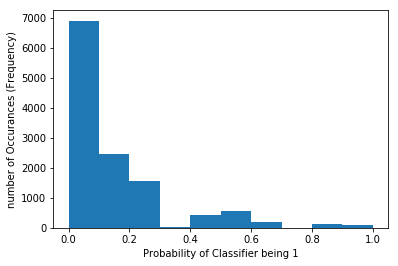

In [0]:
y_pred_probs=clf.predict_proba(X_test)
y_pred_prob=clf.predict_proba(X_test)[:, 1]

#import matplotlib.pyplot as plt
#import seaborn as sns
plt.hist(y_pred_prob)
plt.xlabel('Probability of Classifier being 1')
plt.ylabel("number of Occurances (Frequency)")
plt.show()

Predictions Mean  0.8910738852472283
Accuracies Mean   0.8898389017098719
[[10633   306]
 [ 1040   378]]
AUC: 0.748
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10939
           1       0.55      0.27      0.36      1418

    accuracy                           0.89     12357
   macro avg       0.73      0.62      0.65     12357
weighted avg       0.87      0.89      0.87     12357



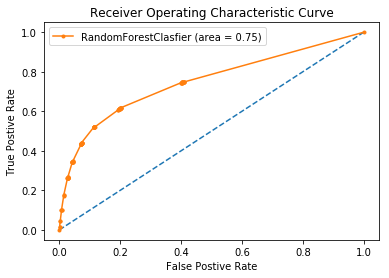

In [0]:
y_pred=clf.predict(X_test)
(y_test==y_pred).mean()
accuracies=cross_val_score (estimator=clf, X=X_train, y=y_train, cv=20)

print ('Predictions Mean ', (y_test==y_pred).mean())
print ('Accuracies Mean  ', accuracies.mean())

cm=confusion_matrix(y_test,y_pred)
print (cm)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

# calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.3f' % auc)

accuracy = metrics.accuracy_score(y_pred, y_test)
balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test)
average_precision = metrics.average_precision_score(y_pred, y_test)
f1_score = metrics.f1_score(y_pred, y_test)    
recall = metrics.recall_score(y_pred, y_test)

report = classification_report(y_test, y_pred)
print(report)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='RandomForestClasfier (area = %0.2f)' % roc_auc)
#plt.plot(fpr, tpr, marker='.')

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
plt.legend()
# show the plot
plt.show()

Above is the basic first Prediction Performance using RandomForestClassifier. But truly somany False Negatives and False Postives, it needs to do better than that.  

Now, will use some Encoding methods to check the Performance

<font color = Green size =3> 
# Random Forest <br> Label Encode instead of dummy variables
</font>

In [0]:
mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_df = df.drop('y', axis=1)
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [0]:
label_df.shape

(41188, 20)

In [0]:
y.shape

(41188,)

In [0]:
##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(label_df, y, test_size=0.30, random_state=110)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

##Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)

from sklearn.linear_model import LogisticRegression
clf_le=RandomForestClassifier()
clf_le.fit(X_train,y_train)


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
X_train.shape

(28831, 20)

Predictions Mean  0.9079064497855467
Mean Accuracies   0.9104084187942485
[[10577   362]
 [  776   642]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10939
           1       0.64      0.45      0.53      1418

    accuracy                           0.91     12357
   macro avg       0.79      0.71      0.74     12357
weighted avg       0.90      0.91      0.90     12357

roc_auc_le -- >  0.9174252435386334
AUC: 0.917


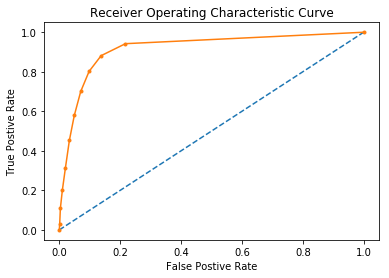

In [0]:
y_pred_le=clf_le.predict(X_test) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
(y_test==y_pred_le).mean()       # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance 

accuracies_le =cross_val_score (estimator=clf_le, X=X_train, y=y_train, cv=20) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

print ('Predictions Mean ', (y_test==y_pred_le).mean()) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print ('Mean Accuracies  ', accuracies_le.mean())       # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

y_pred_prob_le = clf_le.predict_proba(X_test)[:, 1] # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

cm_le=confusion_matrix(y_test,y_pred_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print (cm_le)                            # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

recall_score(y_test, y_pred_le)          # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
roc_curve(y_test, y_pred_le)             # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance



report_le = classification_report(y_test, y_pred_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print(report_le)                         # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance


# calculate roc curve
fpr_le, tpr_le, thresholds_le = roc_curve(y_test, y_pred_prob_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
roc_auc_le = metrics.auc(fpr_le, tpr_le)
print ('roc_auc_le -- > ', roc_auc_le)
# calculate AUC
auc_le = roc_auc_score(y_test, y_pred_prob_le)     # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print('AUC: %.3f' % auc_le)                # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

accuracy_le = metrics.accuracy_score(y_pred_le, y_test)
balanced_accuracy_le = metrics.balanced_accuracy_score(y_pred_le, y_test)
precision_le = metrics.precision_score(y_pred_le, y_test)
average_precision_le = metrics.average_precision_score(y_pred_le, y_test)
f1_score_le = metrics.f1_score(y_pred_le, y_test)
recall_le = metrics.recall_score(y_pred_le, y_test)


plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model

plt.plot(fpr_le, tpr_le, marker='.', label='RandomForestClasfier (area = %0.2f)' %roc_auc_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()

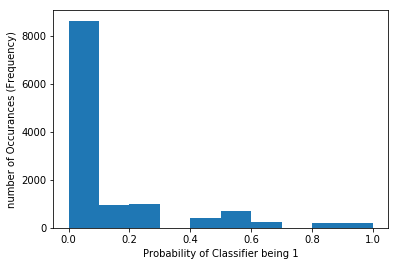

In [0]:
y_pred_probs_le=clf_le.predict_proba(X_test)      # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
y_pred_prob_le=clf_le.predict_proba(X_test)[:, 1] # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

#import matplotlib.pyplot as plt
#import seaborn as sns
plt.hist(y_pred_prob_le)
plt.xlabel('Probability of Classifier being 1')
plt.ylabel("number of Occurances (Frequency)")
plt.show()

<font color=green size=5> 
It seems that label encoding performs much better across the spectrum of different threshold values. All Performance metrics have improved. 
</font>
<br>
<font color=red size=4> 
However, there are a few features in which the label ordering did not make sense. </font>
<br>
<font color=red size=4> 
    For example, days of week:
    {'fri': 1, 'mon': 2, 'thu': 3, 'tue': 4, 'wed': 5}. </font>
<br>
<font color=red size=4> 
    Furthermore, the ‘job’ feature in particular would be more explanatory if converted to dummy variables as one’s job would appear to be an important determinant of whether they open a term deposit and an ordinal scale wouldn’t quite make sense.

Below, custom orders were determined for education, month, and day of the week while dummy variables were created for jobs.
</font>

In [0]:
# Label encode categorical variables.

label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

educ_order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for occupation
X_df = pd.concat([df, pd.get_dummies(df['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(df, 'education', educ_order)
ordered_labels(df, 'month', month_order)
ordered_labels(df, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(df):
    if df[col].dtype == 'object':
        X_df[col] = label_encoder.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X_df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown,job
0,56,1,basic.4y,0,0,0,1,may,mon,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,3
1,57,1,high.school,1,0,0,1,may,mon,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,7
2,37,1,high.school,0,2,0,1,may,mon,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,7
3,40,1,basic.6y,0,0,0,1,may,mon,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,56,1,high.school,0,0,2,1,may,mon,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,7


<font color=brown size=4> 
Now using Cross Validation to bring out the better combination of Parameters

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predictions Mean 0.9093631140244396
Mean Accuracies  0.9089182365844339
[[10612   356]
 [  764   625]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10968
           1       0.64      0.45      0.53      1389

    accuracy                           0.91     12357
   macro avg       0.78      0.71      0.74     12357
weighted avg       0.90      0.91      0.90     12357

AUC: 0.921


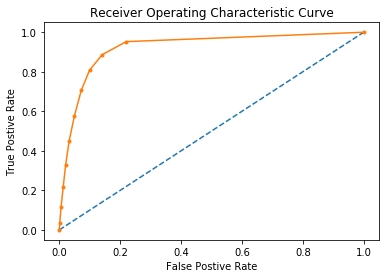

'\nPredictions Mean  0.8917212915756252\nMean Accuracies   0.9088468830649961\n[[10636   303]\n [ 1035   383]]\n              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95     10939\n           1       0.66      0.43      0.52      1418\n\n    accuracy                           0.91     12357\n   macro avg       0.79      0.70      0.74     12357\nweighted avg       0.90      0.91      0.90     12357\n\nAUC: 0.919 '

In [0]:
##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(label_df, y, test_size=0.30, random_state=42)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

##Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)

clf_cdv=RandomForestClassifier() #cdv stands for Custom Orders and Dummy Variables
clf_cdv.fit(X_train,y_train)

y_pred_cdv=clf_cdv.predict(X_test)
(y_test==y_pred_cdv).mean()

accuracies_cdv=cross_val_score (estimator=clf_cdv, X=X_train, y=y_train, cv=20)

print ('predictions Mean', (y_test==y_pred_cdv).mean())
print ('Mean Accuracies ', accuracies_cdv.mean())

cm_cdv=confusion_matrix(y_test,y_pred_cdv)
print (cm_cdv)

y_pred_prob_cdv = clf_cdv.predict_proba(X_test)[:, 1]

recall_score(y_test, y_pred_cdv)
roc_curve(y_test, y_pred_cdv)

report_cdv = classification_report(y_test, y_pred_cdv)
print(report_cdv)

y_pred_prob_cdv = clf_cdv.predict_proba(X_test)[:, 1]

# calculate roc curve
fpr_cdv, tpr_cdv, thresholds_cdv = roc_curve(y_test, y_pred_prob_cdv)

roc_auc_cdv = metrics.auc(fpr_cdv, tpr_cdv)

# calculate AUC
auc_cdv = roc_auc_score(y_test, y_pred_prob_cdv)
print('AUC: %.3f' % auc_cdv)

accuracy_cdv = metrics.accuracy_score(y_pred_cdv, y_test)
balanced_accuracy_cdv = metrics.balanced_accuracy_score(y_pred_cdv, y_test)
precision_cdv = metrics.precision_score(y_pred_cdv, y_test)
average_precision_cdv = metrics.average_precision_score(y_pred_cdv, y_test)
f1_score_cdv = metrics.f1_score(y_pred_cdv, y_test)
recall_cdv = metrics.recall_score(y_pred_cdv, y_test)


plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_cdv, tpr_cdv, marker='.', label='RandomForestClasfier (area = %0.2f)' % roc_auc_cdv) 

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()
'''
Predictions Mean  0.8917212915756252
Mean Accuracies   0.9088468830649961
[[10636   303]
 [ 1035   383]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10939
           1       0.66      0.43      0.52      1418

    accuracy                           0.91     12357
   macro avg       0.79      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357

AUC: 0.919 '''

<font color=blue size=5>
With normalized data and resampled data with the Random Forest Model.
</font>

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predictions Mean  0.8888025638535496
Mean Accuracies   0.9378618223152155
y_pred_prob_res------>   [0.2 0.1 0.  ... 0.  0.3 0. ]
[[8812  332]
 [ 813  340]]
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      9144
           1       0.51      0.29      0.37      1153

    accuracy                           0.89     10297
   macro avg       0.71      0.63      0.66     10297
weighted avg       0.87      0.89      0.88     10297

ROC AUC RES: 0.7355
AUC: 0.735


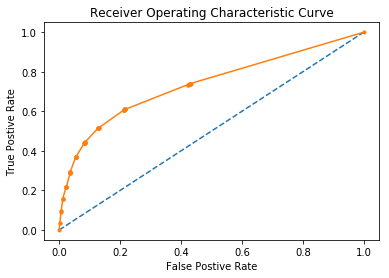

In [0]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

clf_res = RandomForestClassifier() # res stands for Normalized and Resampled dataset
model_res = clf_res.fit(X_train, y_train)

y_pred_res=clf_res.predict(X_test) # res stands for Normalized and Resampled dataset
(y_test==y_pred_res).mean()

accuracies_res=cross_val_score (estimator=clf_res, X=X_train, y=y_train, cv=20) # res stands for Normalized and Resampled dataset

print ('predictions Mean ', (y_test==y_pred_res).mean())
print ('Mean Accuracies  ', accuracies_res.mean())

y_pred_prob_res = clf_res.predict_proba(X_test)[:, 1] # res stands for Normalized and Resampled dataset

print('y_pred_prob_res------>  ', y_pred_prob_res)

cm_res=confusion_matrix(y_test,y_pred_res) # res stands for Normalized and Resampled dataset
print (cm_res)

recall_score(y_test, y_pred_res)
roc_curve(y_test, y_pred_res)

report_res = classification_report(y_test, y_pred_res) # res stands for Normalized and Resampled dataset
print(report_res)


# calculate roc curve
fpr_res, tpr_res, thresholds_res = roc_curve(y_test, y_pred_prob_res) # res stands for Normalized and Resampled dataset
roc_auc_res = metrics.auc(fpr_res, tpr_res)

print('ROC AUC RES: %.4f' % roc_auc_res)
accuracy_res = metrics.accuracy_score(y_pred_res, y_test)
balanced_accuracy_res = metrics.balanced_accuracy_score(y_pred_res, y_test)
precision_res = metrics.precision_score(y_pred_res, y_test)
average_precision_res = metrics.average_precision_score(y_pred_res, y_test)
f1_score_res = metrics.f1_score(y_pred_res, y_test)
recall_res = metrics.recall_score(y_pred_res, y_test)

# calculate AUC
auc_res = roc_auc_score(y_test, y_pred_prob_res)
print('AUC: %.3f' % auc_res)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_res, tpr_res, marker='.' , label='RandomForestClasfier (area = %0.3f)' % roc_auc_res)

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()

<font color=red size=5>
There is drastic fall in the AUC may be because of no standadization methods applied. 
<font color=brown size=5> <br>
Will adopt the MinMaxScaler and constrain the range of values to be between 0 and 1. 

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Predictions Mean MMC  0.8892125920530873
Mean Accuracies MMC   0.8891821011568289
[[10632   336]
 [ 1033   356]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     10968
           1       0.51      0.26      0.34      1389

    accuracy                           0.89     12357
   macro avg       0.71      0.61      0.64     12357
weighted avg       0.87      0.89      0.87     12357

ROC AUC MMC: 0.745
AUC: 0.745


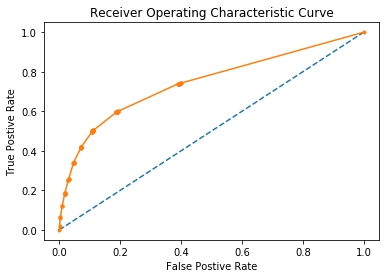

In [0]:

##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.30, random_state=42)

# Normalizing continuous variables

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf_mmc=RandomForestClassifier()                                 # mmc stands for Min Max Scaler and Contrained values between 0 and 1
clf_mmc.fit(X_train,y_train)

y_pred_mmc=clf_mmc.predict(X_test)                               # mmc stands for Min Max Scaler and Contrained values between 0 and 1
(y_test==y_pred_mmc).mean()                                      # mmc stands for Min Max Scaler and Contrained values between 0 and 1

accuracies_mmc=cross_val_score (estimator=clf_mmc, X=X_train, y=y_train, cv=20) # mmc stands for Min Max Scaler and Contrained values between 0 and 1

print ('Predictions Mean MMC ', (y_test==y_pred_mmc).mean())      # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print ('Mean Accuracies MMC  ', accuracies_mmc.mean())            # mmc stands for Min Max Scaler and Contrained values between 0 and 1

y_pred_prob_mmc = clf_mmc.predict_proba(X_test)[:, 1]             # mmc stands for Min Max Scaler and Contrained values between 0 and 1

cm_mmc=confusion_matrix(y_test,y_pred_mmc)                        # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print (cm_mmc)                                                    # mmc stands for Min Max Scaler and Contrained values between 0 and 1

recall_score(y_test, y_pred_mmc)                                  # mmc stands for Min Max Scaler and Contrained values between 0 and 1
roc_curve(y_test, y_pred_mmc)                                     # mmc stands for Min Max Scaler and Contrained values between 0 and 1



report_mmc = classification_report(y_test, y_pred_mmc)            # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print(report_mmc)                                                 # mmc stands for Min Max Scaler and Contrained values between 0 and 1


# calculate roc curve
fpr_mmc, tpr_mmc, thresholds_mmc = roc_curve(y_test, y_pred_prob_mmc)     # mmc stands for Min Max Scaler and Contrained values between 0 and 1
roc_auc_mmc = metrics.auc(fpr_mmc, tpr_mmc)
print('ROC AUC MMC: %.3f' %roc_auc_mmc)

# calculate AUC
auc_mmc = roc_auc_score(y_test, y_pred_prob_mmc)                   # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print('AUC: %.3f' % auc_mmc)                  # mmc stands for Min Max Scaler and Contrained values between 0 and 1

accuracy_mmc = metrics.accuracy_score(y_pred_mmc, y_test)
balanced_accuracy_mmc = metrics.balanced_accuracy_score(y_pred_mmc, y_test)
precision_mmc = metrics.precision_score(y_pred_mmc, y_test)
average_precision_mmc = metrics.average_precision_score(y_pred_mmc, y_test)
f1_score_mmc = metrics.f1_score(y_pred_mmc, y_test)
recall_mmc = metrics.recall_score(y_pred_mmc, y_test)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_mmc, tpr_mmc, marker='.',label='RandomForestClasfier (area = %0.3f)' % roc_auc_mmc) # mmc stands for Min Max Scaler and Contrained values between 0 and 1

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()

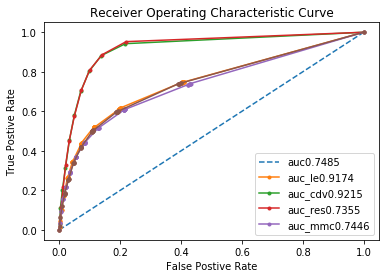

In [0]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.set_cmap(matplotlib.cm.get_cmap)
#plt.set_cmap('Accent_r')
plt.set_cmap('Blues_r')
plt.plot(fpr, tpr, marker='.', label='RandomForestClasfier (area = %0.3f)' % roc_auc)
plt.plot(fpr_le, tpr_le, marker='.', label='RandomForestClasfier (area = %0.3f)' % roc_auc_le)
plt.plot(fpr_cdv, tpr_cdv, marker='.' , label='RandomForestClasfier (area = %0.3f)' % roc_auc_cdv)
plt.plot(fpr_res, tpr_res, marker='.' , label='RandomForestClasfier (area = %0.3f)' % roc_auc_res)
plt.plot(fpr_mmc, tpr_mmc, marker='.' , label='RandomForestClasfier (area = %0.3f)' % roc_auc_mmc)

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
plt.legend(['auc'+str(round(auc,4)), 'auc_le'+str(round(auc_le,4)), 'auc_cdv'+str(round(auc_cdv,4)), 'auc_res'+str(round(auc_res,4)), 
            'auc_mmc'+str(round(auc_mmc,4))], loc='lower right')
# show the plot
plt.show()

In [0]:

#Printing the Performance Metrics in Tabular format.

print (
      'Accuracy            ,'
    , 'AUC                 ,' 
    , 'balanced_accuracy   ,'
    , 'precision           ,'
    , 'average_precision   ,'
    , 'f1_score            ,'
    , 'recall              '
    ) #, balanced_accuracy, precision, average_precision, f1_score, recall, roc_auc)
print ('Normal')
print (
    accuracies.max(),","
    , auc,","
    , balanced_accuracy,","
    , precision,","
    , average_precision,","
    , f1_score,","
    , recall
)
print ('Label Encoding')
print (
    accuracies_le.max(),","
    , auc_le,","
    , balanced_accuracy_le,","
    , precision_le,","
    , average_precision_le,","
    , f1_score_le,","
    , recall_le
)
print ('Label Custom Order and Dummy Variables')
print (
    accuracies_cdv.max(),","
    , auc_cdv,","
    , balanced_accuracy_cdv,","
    , precision_cdv,","
    , average_precision_cdv,","
    , f1_score_cdv,","
    , recall_cdv
)
print ('ReSampling')
print (
    accuracies_res.max(),","
    , auc_res,","
    , balanced_accuracy_res,","
    , precision_res,","
    , average_precision_res,","
    , f1_score_res,","
    , recall_res
)
print ('MinMaxScaler')
print (
    accuracies_mmc.max(),","
    , auc_mmc,","
    , balanced_accuracy_mmc,","
    , precision_mmc,","
    , average_precision_mmc,","
    , f1_score_mmc,","
    , recall_mmc
)

Accuracy            , AUC                 , balanced_accuracy   , precision           , average_precision   , f1_score            , recall              
Normal
0.9064449064449065 , 0.7484763242141219 , 0.7317685436928224 , 0.26657263751763044 , 0.17207974963671252 , 0.35965746907706947 , 0.5526315789473685
Label Encoding
0.9181692094313454 , 0.9174252435386334 , 0.7855451268124016 , 0.4527503526093089 , 0.318802831952763 , 0.5301403798513625 , 0.6394422310756972
Label Custom Order and Dummy Variables
0.9188626907073509 , 0.9214787543473546 , 0.7849730319100892 , 0.4499640028797696 , 0.3154838953749814 , 0.5274261603375527 , 0.6371049949031601
ReSampling
0.9824817518248176 , 0.7354792719968981 , 0.7107424242424243 , 0.2948829141370338 , 0.18143911320904157 , 0.3726027397260274 , 0.5059523809523809
MinMaxScaler
0.8979875086745316 , 0.7445757184064223 , 0.7129476795611595 , 0.25629949604031677 , 0.15904456375560563 , 0.3421432003844305 , 0.5144508670520231


<font color=green size=5>
Label Encoding Model seem doing well with all Metrics being balanced. 

<font color=brown size=6>
Adaptive Boosting. Will try <br> <font color=brown size=5> 
1) Basic Normal <br>
2) Label Encoding <br>
3) Custom Order and Dummy Variables <br>
4) ReSampling <br>
5) MinMaxScaller

In [0]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

df = pd.read_csv('My Drive/MyLearning/MLDLAIPython/Data/TextData/bank-additional-full_prj.csv')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [0]:
# Separating with continuous and categorical variables.

X_cont = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'euribor3m', 'nr.employed']
X_cat = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

cont_df = df[X_cont]
cat_df = df[X_cat]

# Creating dummyX variable dataframe from categorical variables.

X = cont_df.join(pd.get_dummies(cat_df))
y = df.iloc[:, 20].replace(('yes', 'no'), (1, 0))

In [0]:
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.30, random_state=110)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

##Initialize StandardScaler. Standardizing the Feature values to have a common units of measurement
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)

In [0]:
clf = AdaBoostClassifier(learning_rate=0.01)
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
clf.fit(X_train,y_train)
clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

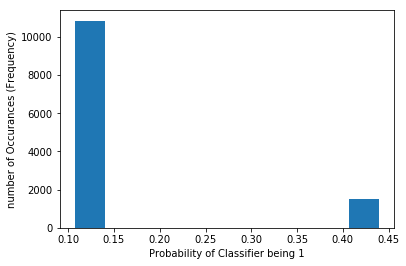

In [0]:
y_pred_probs=clf.predict_proba(X_test)
y_pred_prob=clf.predict_proba(X_test)[:, 1]

#import matplotlib.pyplot as plt
#import seaborn as sns
plt.hist(y_pred_prob)
plt.xlabel('Probability of Classifier being 1')
plt.ylabel("number of Occurances (Frequency)")
plt.show()

Predictions Mean  0.8852472282916566
Accuracies Mean   0.8882453371910868
[[10939     0]
 [ 1418     0]]
AUC: 0.764
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10939
           1       0.00      0.00      0.00      1418

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.78      0.89      0.83     12357



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_

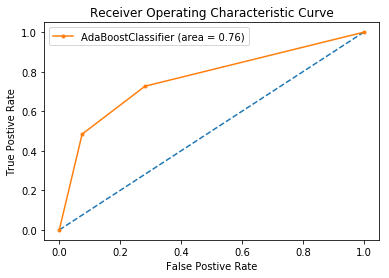

In [0]:
y_pred=clf.predict(X_test)
(y_test==y_pred).mean()
accuracies=cross_val_score (estimator=clf, X=X_train, y=y_train, cv=20)

print ('Predictions Mean ', (y_test==y_pred).mean())
print ('Accuracies Mean  ', accuracies.mean())

cm=confusion_matrix(y_test,y_pred)
print (cm)

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = metrics.auc(fpr, tpr)

# calculate AUC
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: %.3f' % auc)

accuracy = metrics.accuracy_score(y_pred, y_test)
balanced_accuracy = metrics.balanced_accuracy_score(y_pred, y_test)
precision = metrics.precision_score(y_pred, y_test)
average_precision = metrics.average_precision_score(y_pred, y_test)
f1_score = metrics.f1_score(y_pred, y_test)    
recall = metrics.recall_score(y_pred, y_test)

report = classification_report(y_test, y_pred)
print(report)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='AdaBoostClassifier (area = %0.2f)' % roc_auc)
#plt.plot(fpr, tpr, marker='.')

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
plt.legend()
# show the plot
plt.show()

<font color = Green size =3> 
# Adaboost <br> Label Encode instead of dummy variables
</font>

In [0]:
mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_df = df.drop('y', axis=1)
for i, col in enumerate(label_df):
    if label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

In [0]:
label_df.shape

(41188, 20)

In [0]:
y.shape

(41188,)

In [0]:
##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(label_df, y, test_size=0.30, random_state=110)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

##Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)

from sklearn.linear_model import LogisticRegression
clf_le=AdaBoostClassifier(learning_rate=0.01)
clf_le.fit(X_train,y_train)


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.01,
                   n_estimators=50, random_state=None)

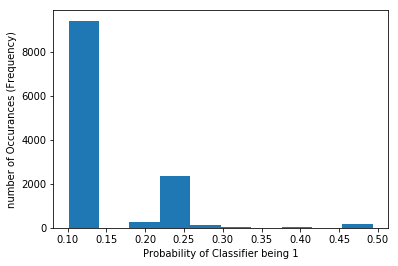

In [0]:
y_pred_probs_le=clf_le.predict_proba(X_test)
y_pred_prob_le=clf_le.predict_proba(X_test)[:, 1]

#import matplotlib.pyplot as plt
#import seaborn as sns
plt.hist(y_pred_prob_le)
plt.xlabel('Probability of Classifier being 1')
plt.ylabel("number of Occurances (Frequency)")
plt.show()

Predictions Mean  0.8852472282916566
Mean Accuracies   0.8882453371910868
[[10939     0]
 [ 1418     0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10939
           1       0.00      0.00      0.00      1418

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.78      0.89      0.83     12357

roc_auc_le -- >  0.8711912618133306
AUC: 0.871


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


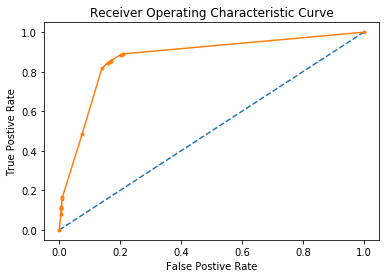

In [0]:
y_pred_le=clf_le.predict(X_test) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
(y_test==y_pred_le).mean()       # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance 

accuracies_le =cross_val_score (estimator=clf_le, X=X_train, y=y_train, cv=20) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

print ('Predictions Mean ', (y_test==y_pred_le).mean()) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print ('Mean Accuracies  ', accuracies_le.mean())       # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

y_pred_prob_le = clf_le.predict_proba(X_test)[:, 1] # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

cm_le=confusion_matrix(y_test,y_pred_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print (cm_le)                            # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

recall_score(y_test, y_pred_le)          # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
roc_curve(y_test, y_pred_le)             # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance



report_le = classification_report(y_test, y_pred_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print(report_le)                         # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance


# calculate roc curve
fpr_le, tpr_le, thresholds_le = roc_curve(y_test, y_pred_prob_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
roc_auc_le = metrics.auc(fpr_le, tpr_le)
print ('roc_auc_le -- > ', roc_auc_le)
# calculate AUC
auc_le = roc_auc_score(y_test, y_pred_prob_le)     # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance
print('AUC: %.3f' % auc_le)                # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

accuracy_le = metrics.accuracy_score(y_pred_le, y_test)
balanced_accuracy_le = metrics.balanced_accuracy_score(y_pred_le, y_test)
precision_le = metrics.precision_score(y_pred_le, y_test)
average_precision_le = metrics.average_precision_score(y_pred_le, y_test)
#f1_score_le = metrics.f1_score(y_pred_le, y_test)
#recall_le = metrics.recall_score(y_pred_le, y_test)


plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model

plt.plot(fpr_le, tpr_le, marker='.', label='AdaBoostClassifier (area = %0.2f)' %roc_auc_le) # le stands for LabelEncoding and will make AUC, ConfusionMatrix for this version of Performance

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()

<font color=green size=5> 
It seems that label encoding performs much better across the spectrum of different threshold values. All Performance metrics have improved. 
</font>
<br>
<font color=red size=4> 
However, there are a few features in which the label ordering did not make sense. </font>
<br>
<font color=red size=4> 
    For example, days of week:
    {'fri': 1, 'mon': 2, 'thu': 3, 'tue': 4, 'wed': 5}. </font>
<br>
<font color=red size=4> 
    Furthermore, the ‘job’ feature in particular would be more explanatory if converted to dummy variables as one’s job would appear to be an important determinant of whether they open a term deposit and an ordinal scale wouldn’t quite make sense.

Below, custom orders were determined for education, month, and day of the week while dummy variables were created for jobs.
</font>

In [0]:
# Label encode categorical variables.

label_encoder = LabelEncoder()
mappings = []

# Desired label orders for categorical columns.

educ_order = ['unknown', 'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
day_order = ['mon', 'tue', 'wed', 'thu', 'fri']

# using cat.codes for order, one hot for high cardinality and weak case of cardinality.

def ordered_labels(df, col, order):
    df[col] = df[col].astype('category')
    df[col] = df[col].cat.reorder_categories(order, ordered=True)
    df[col] = df[col].cat.codes.astype(int)

# Use dummy variables for occupation
X_df = pd.concat([df, pd.get_dummies(df['job'])],axis=1).drop('job',axis=1)

# Use ordered cat.codes for days, months, and education
ordered_labels(df, 'education', educ_order)
ordered_labels(df, 'month', month_order)
ordered_labels(df, 'day_of_week', day_order)

# Same label encoding for rest since low cardinality
for i, col in enumerate(df):
    if df[col].dtype == 'object':
        X_df[col] = label_encoder.fit_transform(np.array(df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

X_df.head()

,age,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown,job
0,56,1,basic.4y,0,0,0,1,may,mon,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,1,0,0,0,0,0,0,0,0,3
1,57,1,high.school,1,0,0,1,may,mon,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,7
2,37,1,high.school,0,2,0,1,may,mon,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,7
3,40,1,basic.6y,0,0,0,1,may,mon,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,56,1,high.school,0,0,2,1,may,mon,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,0,1,0,0,0,0,7


<font color=brown size=4> 
Now using Cross Validation to bring out the better combination of Parameters

predictions Mean 0.8875940762320952
Mean Accuracies  0.8872395354589825
[[10968     0]
 [ 1389     0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10968
           1       0.00      0.00      0.00      1389

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.79      0.89      0.83     12357



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_

AUC: 0.848


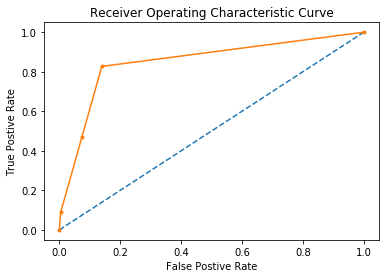

'\nPredictions Mean  0.8917212915756252\nMean Accuracies   0.9088468830649961\n[[10636   303]\n [ 1035   383]]\n              precision    recall  f1-score   support\n\n           0       0.93      0.97      0.95     10939\n           1       0.66      0.43      0.52      1418\n\n    accuracy                           0.91     12357\n   macro avg       0.79      0.70      0.74     12357\nweighted avg       0.90      0.91      0.90     12357\n\nAUC: 0.919 '

In [0]:

##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(label_df, y, test_size=0.30, random_state=42)

#Convert DataFrame to Numpy array

Xtrain=X_train.values
Xtest=X_test.values
ytrain=y_train.values
ytest=y_test.values

##Initialize StandardScaler
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

#Transform the training data
X_train=sc.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=X_test.columns)

#Transform the testing data
X_test=sc.transform(X_test)
X_test=pd.DataFrame(X_test,columns=X_train.columns)

clf_cdv=AdaBoostClassifier(learning_rate=0.001) #cdv stands for Custom Orders and Dummy Variables
clf_cdv.fit(X_train,y_train)

y_pred_cdv=clf_cdv.predict(X_test)
(y_test==y_pred_cdv).mean()

accuracies_cdv=cross_val_score (estimator=clf_cdv, X=X_train, y=y_train, cv=20)

print ('predictions Mean', (y_test==y_pred_cdv).mean())
print ('Mean Accuracies ', accuracies_cdv.mean())

cm_cdv=confusion_matrix(y_test,y_pred_cdv)
print (cm_cdv)

y_pred_prob_cdv = clf_cdv.predict_proba(X_test)[:, 1]

recall_score(y_test, y_pred_cdv)
roc_curve(y_test, y_pred_cdv)

report_cdv = classification_report(y_test, y_pred_cdv)
print(report_cdv)

y_pred_prob_cdv = clf_cdv.predict_proba(X_test)[:, 1]

# calculate roc curve
fpr_cdv, tpr_cdv, thresholds_cdv = roc_curve(y_test, y_pred_prob_cdv)

roc_auc_cdv = metrics.auc(fpr_cdv, tpr_cdv)

# calculate AUC
auc_cdv = roc_auc_score(y_test, y_pred_prob_cdv)
print('AUC: %.3f' % auc_cdv)

accuracy_cdv = metrics.accuracy_score(y_pred_cdv, y_test)
balanced_accuracy_cdv = metrics.balanced_accuracy_score(y_pred_cdv, y_test)
precision_cdv = metrics.precision_score(y_pred_cdv, y_test)
average_precision_cdv = metrics.average_precision_score(y_pred_cdv, y_test)
f1_score_cdv = metrics.f1_score(y_pred_cdv, y_test)
recall_cdv = metrics.recall_score(y_pred_cdv, y_test)


plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_cdv, tpr_cdv, marker='.', label='AdaBoostClassifier (area = %0.2f)' % roc_auc_cdv) 

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()
'''
Predictions Mean  0.8917212915756252
Mean Accuracies   0.9088468830649961
[[10636   303]
 [ 1035   383]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10939
           1       0.66      0.43      0.52      1418

    accuracy                           0.91     12357
   macro avg       0.79      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357

AUC: 0.919 '''

<font color=blue size=5>
With normalized data and resampled data with the Random Forest Model.

predictions Mean  0.8744840980820587
Mean Accuracies   0.6974694452576112
y_pred_prob_res------>   [0.85628554 0.36730026 0.36730026 ... 0.36730026 0.85628554 0.36730026]
[[10119   820]
 [  731   687]]
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10939
           1       0.46      0.48      0.47      1418

    accuracy                           0.87     12357
   macro avg       0.69      0.70      0.70     12357
weighted avg       0.88      0.87      0.88     12357

ROC AUC RES: 0.7048
AUC: 0.705


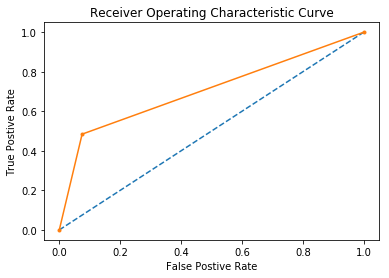

In [0]:
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 110)

sm = SMOTE(random_state = 2)
X_train, y_train = sm.fit_sample(X_train, y_train.ravel())

clf_res = AdaBoostClassifier(learning_rate=0.001) # res stands for Normalized and Resampled dataset
model_res = clf_res.fit(X_train, y_train)

y_pred_res=clf_res.predict(X_test) # res stands for Normalized and Resampled dataset
(y_test==y_pred_res).mean()

accuracies_res=cross_val_score (estimator=clf_res, X=X_train, y=y_train, cv=20) # res stands for Normalized and Resampled dataset

print ('predictions Mean ', (y_test==y_pred_res).mean())
print ('Mean Accuracies  ', accuracies_res.mean())

y_pred_prob_res = clf_res.predict_proba(X_test)[:, 1] # res stands for Normalized and Resampled dataset

print('y_pred_prob_res------>  ', y_pred_prob_res)

cm_res=confusion_matrix(y_test,y_pred_res) # res stands for Normalized and Resampled dataset
print (cm_res)

recall_score(y_test, y_pred_res)
roc_curve(y_test, y_pred_res)

report_res = classification_report(y_test, y_pred_res) # res stands for Normalized and Resampled dataset
print(report_res)


# calculate roc curve
fpr_res, tpr_res, thresholds_res = roc_curve(y_test, y_pred_prob_res) # res stands for Normalized and Resampled dataset
roc_auc_res = metrics.auc(fpr_res, tpr_res)

print('ROC AUC RES: %.4f' % roc_auc_res)
accuracy_res = metrics.accuracy_score(y_pred_res, y_test)
balanced_accuracy_res = metrics.balanced_accuracy_score(y_pred_res, y_test)
precision_res = metrics.precision_score(y_pred_res, y_test)
average_precision_res = metrics.average_precision_score(y_pred_res, y_test)
f1_score_res = metrics.f1_score(y_pred_res, y_test)
recall_res = metrics.recall_score(y_pred_res, y_test)

# calculate AUC
auc_res = roc_auc_score(y_test, y_pred_prob_res)
print('AUC: %.3f' % auc_res)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_res, tpr_res, marker='.' , label='AdaBoostClassifier (area = %0.3f)' % roc_auc_res)

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()

<font color=red size=5>
There is drastic fall in the AUC may be because of no standadization methods applied. 
<font color=brown size=5> <br>
Will adopt the MinMaxScaler and constrain the range of values to be between 0 and 1. 

Predictions Mean MMC  0.8852472282916566
Mean Accuracies MMC   0.8882453371910868
[[10939     0]
 [ 1418     0]]
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     10939
           1       0.00      0.00      0.00      1418

    accuracy                           0.89     12357
   macro avg       0.44      0.50      0.47     12357
weighted avg       0.78      0.89      0.83     12357

ROC AUC MMC: 0.705
AUC: 0.705


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1745: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_

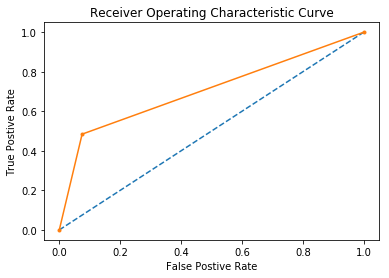

In [0]:
##Split The Data into Train and Test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(X, y, test_size=0.30, random_state=110)

# Normalizing continuous variables

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

clf_mmc=AdaBoostClassifier(learning_rate=0.001)                # mmc stands for Min Max Scaler and Contrained values between 0 and 1
clf_mmc.fit(X_train,y_train)

y_pred_mmc=clf_mmc.predict(X_test)                               # mmc stands for Min Max Scaler and Contrained values between 0 and 1
(y_test==y_pred_mmc).mean()                                      # mmc stands for Min Max Scaler and Contrained values between 0 and 1

accuracies_mmc=cross_val_score (estimator=clf_mmc, X=X_train, y=y_train, cv=20) # mmc stands for Min Max Scaler and Contrained values between 0 and 1

print ('Predictions Mean MMC ', (y_test==y_pred_mmc).mean())      # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print ('Mean Accuracies MMC  ', accuracies_mmc.mean())            # mmc stands for Min Max Scaler and Contrained values between 0 and 1

y_pred_prob_mmc = clf_mmc.predict_proba(X_test)[:, 1]             # mmc stands for Min Max Scaler and Contrained values between 0 and 1

cm_mmc=confusion_matrix(y_test,y_pred_mmc)                        # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print (cm_mmc)                                                    # mmc stands for Min Max Scaler and Contrained values between 0 and 1

recall_score(y_test, y_pred_mmc)                                  # mmc stands for Min Max Scaler and Contrained values between 0 and 1
roc_curve(y_test, y_pred_mmc)                                     # mmc stands for Min Max Scaler and Contrained values between 0 and 1



report_mmc = classification_report(y_test, y_pred_mmc)            # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print(report_mmc)                                                 # mmc stands for Min Max Scaler and Contrained values between 0 and 1


# calculate roc curve
fpr_mmc, tpr_mmc, thresholds_mmc = roc_curve(y_test, y_pred_prob_mmc)     # mmc stands for Min Max Scaler and Contrained values between 0 and 1
roc_auc_mmc = metrics.auc(fpr_mmc, tpr_mmc)
print('ROC AUC MMC: %.3f' %roc_auc_mmc)

# calculate AUC
auc_mmc = roc_auc_score(y_test, y_pred_prob_mmc)                   # mmc stands for Min Max Scaler and Contrained values between 0 and 1
print('AUC: %.3f' % auc_mmc)                  # mmc stands for Min Max Scaler and Contrained values between 0 and 1

accuracy_mmc = metrics.accuracy_score(y_pred_mmc, y_test)
balanced_accuracy_mmc = metrics.balanced_accuracy_score(y_pred_mmc, y_test)
precision_mmc = metrics.precision_score(y_pred_mmc, y_test)
average_precision_mmc = metrics.average_precision_score(y_pred_mmc, y_test)
f1_score_mmc = metrics.f1_score(y_pred_mmc, y_test)
recall_mmc = metrics.recall_score(y_pred_mmc, y_test)

plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr_mmc, tpr_mmc, marker='.',label='AdaBoostClassifier (area = %0.3f)' % roc_auc_mmc) # mmc stands for Min Max Scaler and Contrained values between 0 and 1

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
# show the plot
plt.show()

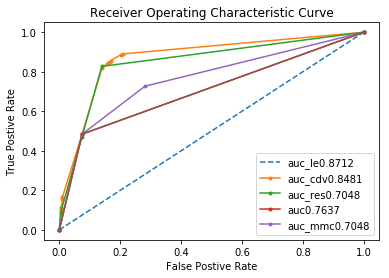

In [0]:
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
#plt.set_cmap(matplotlib.cm.get_cmap)
#plt.set_cmap('Accent_r')
plt.set_cmap('Blues_r')

plt.plot(fpr_le, tpr_le, marker='.', label='AdaBoostClassifier (area = %0.3f)' % roc_auc_le)
plt.plot(fpr_cdv, tpr_cdv, marker='.' , label='AdaBoostClassifier (area = %0.3f)' % roc_auc_cdv)
plt.plot(fpr_res, tpr_res, marker='.' , label='AdaBoostClassifier (area = %0.3f)' % roc_auc_res)
plt.plot(fpr, tpr, marker='.', label='AdaBoostClassifier (area = %0.3f)' % roc_auc)
plt.plot(fpr_mmc, tpr_mmc, marker='.' , label='AdaBoostClassifier (area = %0.3f)' % roc_auc_mmc)

plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Postive Rate') 
plt.ylabel('True Postive Rate')
#plt.legend(['auc'+str(round(auc,4)), 'auc_le'+str(round(auc_le,4)), 'auc_cdv'+str(round(auc_cdv,4)), 'auc_res'+str(round(auc_res,4)), 
#            'auc_mmc'+str(round(auc_mmc,4))], loc='lower right')
plt.legend(['auc_le'+str(round(auc_le,4)),  'auc_cdv'+str(round(auc_cdv,4)), 
            'auc_res'+str(round(auc_res,4)), 'auc'+str(round(auc,4)), 'auc_mmc'+str(round(auc_mmc,4))], loc='lower right')
# show the plot
plt.show()

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "n_estimators": [50, 100, 150, 200, 250]
             }


DTC = DecisionTreeClassifier(random_state = 11, max_features= "auto", class_weight = "balanced",max_depth = None)

ABC = AdaBoostClassifier(base_estimator = DTC)

# run grid search
grid_search_ABC = GridSearchCV(ABC, param_grid=param_grid, scoring = 'roc_auc', cv=5)

grid_search_ABC.fit(X_train, y_train)
#scores = cross_val_score(grid_search_ABC, X_train, y_train, cv=5)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features='auto',
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                        

In [0]:
scores = cross_val_score(grid_search_ABC, X_train, y_train, cv=5)

In [0]:
dtrain_predictions = grid_search_ABC.predict(y_test)
dtrain_predprob = grid_search_ABC.predict_proba(y_test)
#Print model report:
print ("\nModel Report")
print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain_predictions, y_test))
print ("AUC Score (Train): %f" % metrics.roc_auc_score(X_test, dtrain_predprob))    #(y_test, y_pred_prob_mmc)  
if performCV:
  print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(scores),np.std(scores),np.min(scores),np.max(scores)))
        
#Print Feature Importance:
if printFeatureImportance:
  feat_imp = pd.Series(grid_search_ABC.feature_importances_, predictors).sort_values(ascending=False)
  feat_imp.plot(kind='bar', title='Feature Importances')
  
  
plt.ylabel('Feature Importance Score')
plt.show()

ValueError: ignored

In [0]:
#Choose all predictors except target & IDcols
predictors = [x for x in X_train if x not in [y_test]]

ValueError: ignored

In [0]:
dtrain_predprob

array([[0.99676457, 0.00323543],
       [0.98165794, 0.01834206],
       [0.99177959, 0.00822041],
       ...,
       [0.98921886, 0.01078114],
       [0.99138905, 0.00861095],
       [0.99526669, 0.00473331]])